In [41]:
# 美股量化交易策略实现 - 完整版
# 使用真实美股数据，实现5种经典量化策略

# --- 环境设置 ---
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib import rcParams
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# --- 环境设置 ---
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['font.sans-serif'] = ['Misans']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")

使用设备: cuda


In [42]:
# --- 配置参数 ---
TICKERS = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'TSLA', 'META', 'NFLX']
START_DATE = '2023-01-01'
END_DATE = '2025-08-30'

# --- 数据获取和预处理 ---
print("正在下载数据...")
df_data = yf.download(TICKERS, start=START_DATE, end=END_DATE, progress=False)
df_data

正在下载数据...


Price            Close                                                  \
Ticker            AAPL        AMZN       GOOGL        META        MSFT   
Date                                                                     
2023-01-03  123.330658   85.820000   88.509537  124.059402  234.423584   
2023-01-04  124.602722   85.139999   87.476669  126.675056  224.169113   
2023-01-05  123.281349   83.120003   85.609543  126.247391  217.525284   
2023-01-06  127.817375   86.080002   86.741730  129.310608  220.088882   
2023-01-09  128.339966   87.360001   87.417068  128.763580  222.231750   
...                ...         ...         ...         ...         ...   
2025-08-25  227.160004  227.940002  208.303696  753.299988  504.260010   
2025-08-26  229.309998  228.710007  206.954895  754.099976  502.040009   
2025-08-27  230.490005  229.119995  207.294586  747.380005  506.739990   
2025-08-28  232.559998  231.600006  211.450882  751.109985  509.640015   
2025-08-29  232.139999  229.000000  212.719742  738.700012  506.690002   

Price                                                  High              ...  \
Ticker             NFLX        NVDA        TSLA        AAPL        AMZN  ...   
Date                                                                     ...   
2023-01-03   294.950012   14.301481  108.099998  129.079575   86.959999  ...   
2023-01-04   309.410004   14.735069  113.639999  126.870739   86.980003  ...   
2023-01-05   309.700012   14.251527  110.339996  125.993105   85.419998  ...   
2023-01-06   315.549988   14.844967  113.059998  128.478056   86.400002  ...   
2023-01-09   315.170013   15.613240  119.769997  131.554638   89.480003  ...   
...                 ...         ...         ...         ...         ...  ...   
2025-08-25  1218.069946  179.799866  346.600006  229.300003  229.600006  ...   
2025-08-26  1226.089966  181.759750  351.670013  229.490005  229.000000  ...   
2025-08-27  1223.500000  181.589767  349.600006  230.899994  229.869995  ...   
2025-08-28  1231.449951  180.159836  345.980011  233.410004  232.710007  ...   
2025-08-29  1208.250000  174.170166  333.869995  233.380005  231.809998  ...   

Price             Open                 Volume                                \
Ticker            NVDA        TSLA       AAPL      AMZN     GOOGL      META   
Date                                                                          
2023-01-03   14.836975  118.470001  112117500  76706000  28131200  35528500   
2023-01-04   14.553242  109.110001   89113600  68885100  34854800  32397100   
2023-01-05   14.477313  110.510002   80962700  67930800  27194400  25447100   
2023-01-06   14.460330  103.000000   87754700  83303400  41381500  27584500   
2023-01-09   15.269565  118.959999   70790800  65266100  29003900  26649100   
...                ...         ...        ...       ...       ...       ...   
2025-08-25  178.339957  338.899994   30983100  22633700  29928900   6861200   
2025-08-26  180.049840  344.929993   54575100  26105400  28464100   7601800   
2025-08-27  181.969736  351.940002   31259500  21254500  23022900   8315400   
2025-08-28  180.809808  350.910004   38074700  33679600  32339300   7468000   
2025-08-29  178.099952  347.230011   39418400  26199200  39728400   9070500   

Price                                                
Ticker          MSFT     NFLX       NVDA       TSLA  
Date                                                 
2023-01-03  25740000  6764000  401277000  231402800  
2023-01-04  50623400  9345100  431324000  180389000  
2023-01-05  39585600  8328400  389168000  157986300  
2023-01-06  43613600  8959800  405044000  220911100  
2023-01-09  27369800  6766600  504231000  190284000  
...              ...      ...        ...        ...  
2025-08-25  21638600  2812000  163012800   86670000  
2025-08-26  30835700  1985700  168688200   76651600  
2025-08-27  17277900  1664500  235518900   65519000  
2025-08-28  18015600  1950300  281787800   67903200  
2025-08-29  20961600  3209800  24

In [43]:
# 检查数据结构
print(f"数据形状: {df_data.shape}")
print(f"数据列: {df_data.columns.levels[0].tolist()}")
print(f"股票代码: {df_data.columns.levels[1].tolist()}")

# 提取收盘价数据
df_prices = df_data['Close'].copy()
df_prices = df_prices.dropna()  # 删除缺失值

print(f"\n收盘价数据形状: {df_prices.shape}")
print("前5行数据:")
df_prices.head()

数据形状: (667, 40)
数据列: ['Close', 'High', 'Low', 'Open', 'Volume']
股票代码: ['AAPL', 'AMZN', 'GOOGL', 'META', 'MSFT', 'NFLX', 'NVDA', 'TSLA']

收盘价数据形状: (667, 8)
前5行数据:


Ticker,AAPL,AMZN,GOOGL,META,MSFT,NFLX,NVDA,TSLA
Date,,,,,,,,
2023-01-03,123.330658,85.820000,88.509537,124.059402,234.423584,294.950012,14.301481,108.099998
2023-01-04,124.602722,85.139999,87.476669,126.675056,224.169113,309.410004,14.735069,113.639999
2023-01-05,123.281349,83.120003,85.609543,126.247391,217.525284,309.700012,14.251527,110.339996
2023-01-06,127.817375,86.080002,86.741730,129.310608,220.088882,315.549988,14.844967,113.059998
2023-01-09,128.339966,87.360001,87.417068,128.763580,222.231750,315.170013,15.613240,119.769997


=== 1. 基础数据统计分析 ===
基础统计信息:
Ticker    AAPL    AMZN   GOOGL    META    MSFT     NFLX    NVDA    TSLA
count   667.00  667.00  667.00  667.00  667.00   667.00  667.00  667.00
mean    195.37  167.70  149.66  452.13  382.74   669.31   88.71  247.44
std      28.35   41.54   29.81  172.72   69.23   288.77   47.38   69.63
min     123.28   83.12   85.61  124.06  217.53   292.76   14.25  108.10
25%     173.94  132.27  129.24  300.59  327.81   427.52   44.38  191.89
50%     191.56  177.23  153.86  484.91  399.81   617.52   90.57  239.20
75%     220.99  199.07  172.08  585.55  423.92   896.29  129.86  282.06
max     258.10  242.06  212.72  790.00  534.76  1339.13  183.15  479.86

价格变动统计:
              起始价格         结束价格          最高价         最低价   总涨幅(%)
Ticker                                                           
AAPL    123.330658   232.139999   258.103729  123.281349    88.23
AMZN     85.820000   229.000000   242.059998   83.120003   166.84
GOOGL    88.509537   212.719742   212.719742   85.6

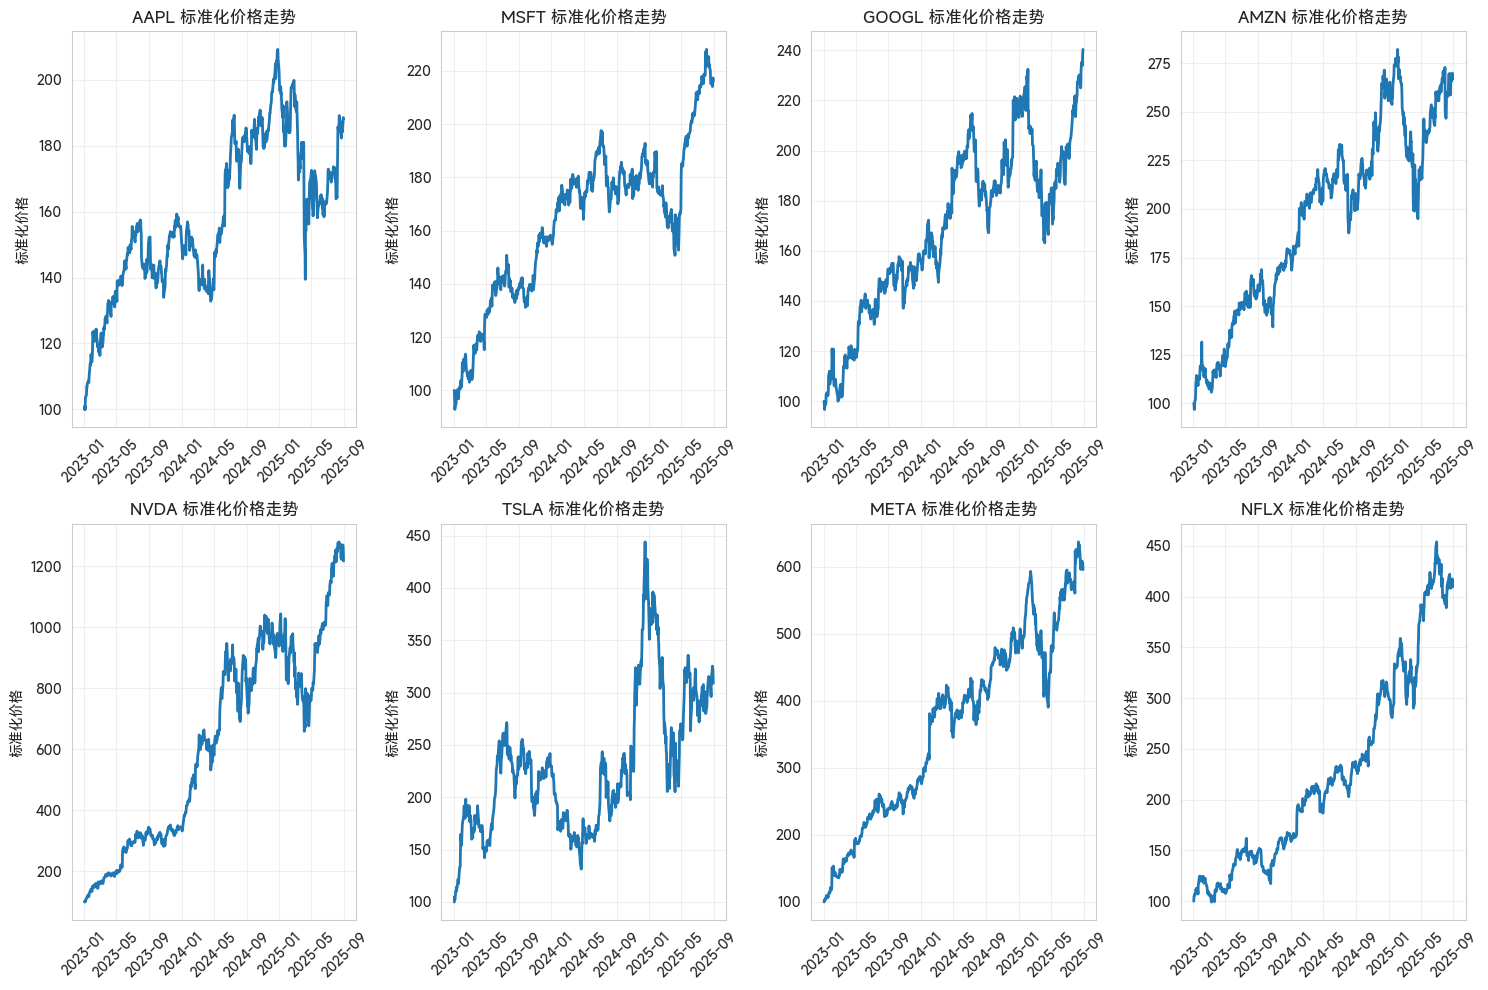

In [44]:
# %%
# === 1. 基础数据统计分析 ===
print("=== 1. 基础数据统计分析 ===")

# 基础统计信息
basic_stats = df_prices.describe()
print("基础统计信息:")
print(basic_stats.round(2))

# 价格范围分析
price_range = pd.DataFrame({
    '起始价格': df_prices.iloc[0],
    '结束价格': df_prices.iloc[-1],
    '最高价': df_prices.max(),
    '最低价': df_prices.min(),
    '总涨幅(%)': ((df_prices.iloc[-1] / df_prices.iloc[0] - 1) * 100).round(2)
})

print("\n价格变动统计:")
print(price_range)

# 可视化价格走势
plt.figure(figsize=(15, 10))
for i, ticker in enumerate(TICKERS):
    plt.subplot(2, 4, i+1)
    normalized_prices = df_prices[ticker] / df_prices[ticker].iloc[0] * 100
    plt.plot(normalized_prices.index, normalized_prices, label=ticker, linewidth=2)
    plt.title(f'{ticker} 标准化价格走势', fontsize=12)
    plt.ylabel('标准化价格')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


=== 2. 收益率分析 ===
收益率统计:
        年化收益率(%)  年化波动率(%)   夏普比率  最大单日涨幅(%)  最大单日跌幅(%)  正收益交易日(%)
Ticker                                                            
AAPL       27.33     26.17  1.045      15.33      -9.25      54.95
AMZN       42.27     32.03  1.320      11.98      -8.98      53.00
GOOGL      37.72     30.07  1.254      10.22      -9.51      55.86
META       74.92     39.01  1.920      23.28     -10.56      53.30
MSFT       31.99     23.77  1.346      10.13      -6.18      54.20
NFLX       59.10     34.01  1.738      16.05      -9.09      53.30
NVDA      107.93     51.80  2.084      24.37     -16.97      56.01
TSLA       61.37     61.52  0.997      22.69     -15.43      51.35


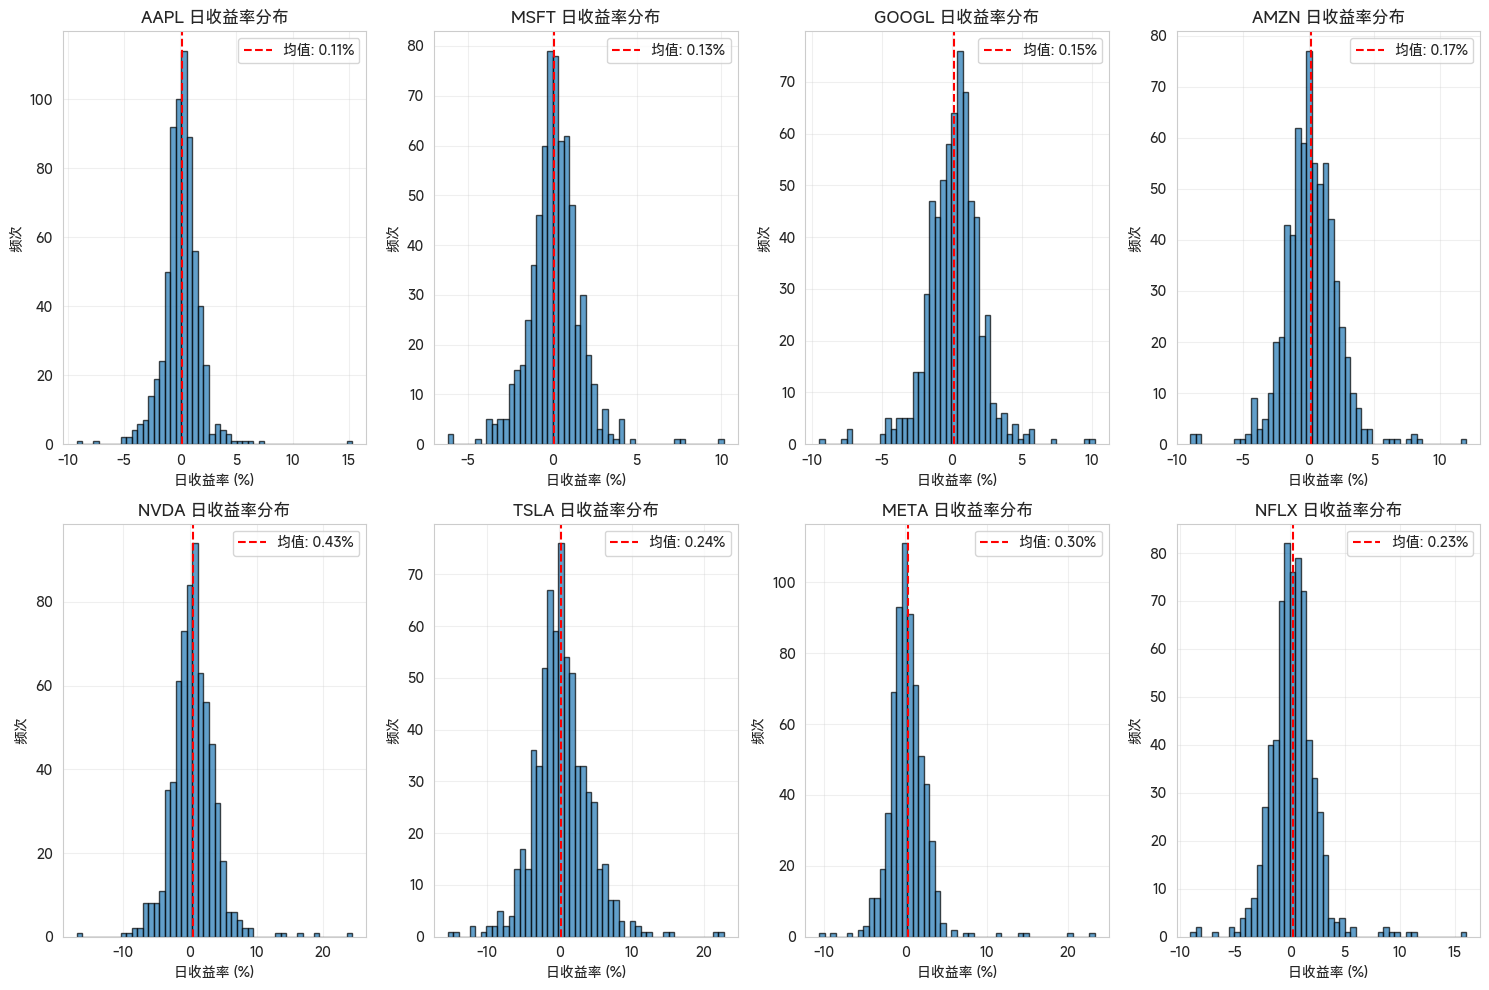

In [45]:
# %%
# === 2. 收益率分析 ===
print("\n=== 2. 收益率分析 ===")

# 计算日收益率
df_returns = df_prices.pct_change().dropna()

# 收益率统计
return_stats = pd.DataFrame({
    '年化收益率(%)': (df_returns.mean() * 252 * 100).round(2),
    '年化波动率(%)': (df_returns.std() * np.sqrt(252) * 100).round(2),
    '夏普比率': ((df_returns.mean() * 252) / (df_returns.std() * np.sqrt(252))).round(3),
    '最大单日涨幅(%)': (df_returns.max() * 100).round(2),
    '最大单日跌幅(%)': (df_returns.min() * 100).round(2),
    '正收益交易日(%)': ((df_returns > 0).mean() * 100).round(2)
})

print("收益率统计:")
print(return_stats)

# 收益率分布可视化
plt.figure(figsize=(15, 10))
for i, ticker in enumerate(TICKERS):
    plt.subplot(2, 4, i+1)
    plt.hist(df_returns[ticker] * 100, bins=50, alpha=0.7, edgecolor='black')
    plt.title(f'{ticker} 日收益率分布', fontsize=12)
    plt.xlabel('日收益率 (%)')
    plt.ylabel('频次')
    plt.axvline(df_returns[ticker].mean() * 100, color='red', linestyle='--', 
                label=f'均值: {df_returns[ticker].mean()*100:.2f}%')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



=== 3. 相关性分析 ===
股票间收益率相关性矩阵:
Ticker   AAPL   AMZN  GOOGL   META   MSFT   NFLX   NVDA   TSLA
Ticker                                                        
AAPL    1.000  0.489  0.470  0.441  0.515  0.353  0.389  0.455
AMZN    0.489  1.000  0.599  0.634  0.640  0.402  0.475  0.416
GOOGL   0.470  0.599  1.000  0.519  0.541  0.326  0.420  0.382
META    0.441  0.634  0.519  1.000  0.595  0.364  0.458  0.346
MSFT    0.515  0.640  0.541  0.595  1.000  0.434  0.550  0.369
NFLX    0.353  0.402  0.326  0.364  0.434  1.000  0.400  0.286
NVDA    0.389  0.475  0.420  0.458  0.550  0.400  1.000  0.383
TSLA    0.455  0.416  0.382  0.346  0.369  0.286  0.383  1.000


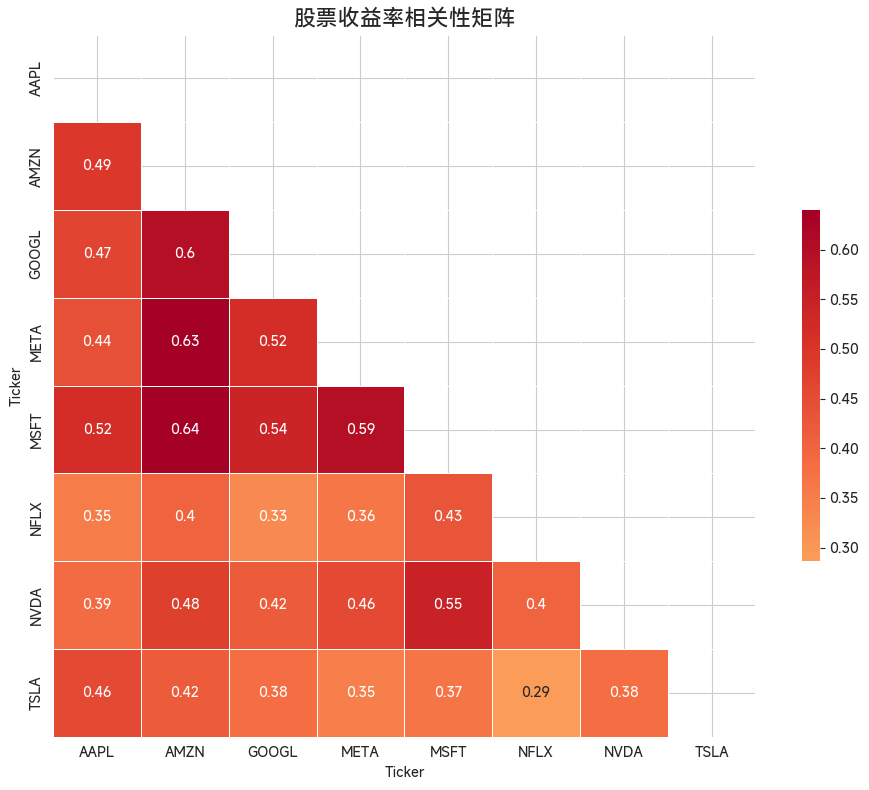


特殊相关性配对:
    股票1   股票2   相关系数   类型
0  NFLX  TSLA  0.286  低相关


In [46]:
# %%
# === 3. 相关性分析 ===
print("\n=== 3. 相关性分析 ===")

# 计算相关系数矩阵
correlation_matrix = df_returns.corr()
print("股票间收益率相关性矩阵:")
print(correlation_matrix.round(3))

# 相关性热力图
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='RdYlBu_r', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .5})
plt.title('股票收益率相关性矩阵', fontsize=16)
plt.tight_layout()
plt.show()

# 识别高相关和低相关配对
def get_correlation_pairs(corr_matrix, threshold_high=0.7, threshold_low=0.3):
    pairs = []
    stocks = corr_matrix.index
    
    for i in range(len(stocks)):
        for j in range(i+1, len(stocks)):
            corr_val = corr_matrix.iloc[i, j]
            if corr_val > threshold_high:
                pairs.append((stocks[i], stocks[j], corr_val, '高相关'))
            elif corr_val < threshold_low:
                pairs.append((stocks[i], stocks[j], corr_val, '低相关'))
    
    return pd.DataFrame(pairs, columns=['股票1', '股票2', '相关系数', '类型'])

correlation_pairs = get_correlation_pairs(correlation_matrix)
if not correlation_pairs.empty:
    print("\n特殊相关性配对:")
    print(correlation_pairs.round(3))

In [47]:
# %%
# === 4. 技术指标计算 ===
print("\n=== 4. 技术指标计算 ===")

def calculate_technical_indicators(prices):
    """计算技术指标"""
    df_tech = pd.DataFrame(index=prices.index)
    
    for ticker in prices.columns:
        price_series = prices[ticker]
        
        # 移动平均线
        df_tech[f'{ticker}_SMA_20'] = price_series.rolling(20).mean()
        df_tech[f'{ticker}_SMA_50'] = price_series.rolling(50).mean()
        df_tech[f'{ticker}_EMA_12'] = price_series.ewm(span=12).mean()
        df_tech[f'{ticker}_EMA_26'] = price_series.ewm(span=26).mean()
        
        # MACD
        df_tech[f'{ticker}_MACD'] = df_tech[f'{ticker}_EMA_12'] - df_tech[f'{ticker}_EMA_26']
        df_tech[f'{ticker}_MACD_Signal'] = df_tech[f'{ticker}_MACD'].ewm(span=9).mean()
        df_tech[f'{ticker}_MACD_Hist'] = df_tech[f'{ticker}_MACD'] - df_tech[f'{ticker}_MACD_Signal']
        
        # RSI
        delta = price_series.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        rs = gain / loss
        df_tech[f'{ticker}_RSI'] = 100 - (100 / (1 + rs))
        
        # 布林带
        df_tech[f'{ticker}_BB_Middle'] = price_series.rolling(20).mean()
        bb_std = price_series.rolling(20).std()
        df_tech[f'{ticker}_BB_Upper'] = df_tech[f'{ticker}_BB_Middle'] + (bb_std * 2)
        df_tech[f'{ticker}_BB_Lower'] = df_tech[f'{ticker}_BB_Middle'] - (bb_std * 2)
        df_tech[f'{ticker}_BB_Position'] = ((price_series - df_tech[f'{ticker}_BB_Lower']) / 
                                          (df_tech[f'{ticker}_BB_Upper'] - df_tech[f'{ticker}_BB_Lower']))
    
    return df_tech

# 计算技术指标
df_technical = calculate_technical_indicators(df_prices)

# 显示最新技术指标
latest_tech = pd.DataFrame()
for ticker in TICKERS:
    latest_tech[ticker] = {
        '当前价格': df_prices[ticker].iloc[-1],
        'RSI': df_technical[f'{ticker}_RSI'].iloc[-1],
        'MACD': df_technical[f'{ticker}_MACD'].iloc[-1],
        '布林带位置': df_technical[f'{ticker}_BB_Position'].iloc[-1],
        '相对20日均线(%)': ((df_prices[ticker].iloc[-1] / 
                           df_technical[f'{ticker}_SMA_20'].iloc[-1] - 1) * 100)
    }

latest_tech = pd.DataFrame(latest_tech).T
print("最新技术指标:")
print(latest_tech.round(3))


=== 4. 技术指标计算 ===
最新技术指标:
          当前价格     RSI   MACD  布林带位置  相对20日均线(%)
AAPL    232.14  60.394  4.849  0.676       2.853
MSFT    506.69  36.857 -0.919  0.273      -1.688
GOOGL   212.72  72.446  5.520  0.993       5.017
AMZN    229.00  61.397  1.711  0.671       1.702
NVDA    174.17  35.745  2.106 -0.002      -3.071
TSLA    333.87  46.819  5.942  0.526       0.391
META    738.70  39.233  3.754  0.106      -3.130
NFLX   1208.25  46.934  2.452  0.483      -0.137



=== 5. 风险指标计算 ===
风险指标统计:
        年化收益率   年化波动率    夏普比率  Sortino比率    最大回撤  VaR_95%  CVaR_95%      偏度  \
AAPL   0.2733  0.2617  1.0445     1.4827 -0.3336  -0.0249   -0.0364  0.8479   
AMZN   0.4227  0.3203  1.3197     1.9848 -0.3088  -0.0271   -0.0427  0.1612   
GOOGL  0.3772  0.3007  1.2543     1.7647 -0.2981  -0.0266   -0.0426 -0.0741   
META   0.7492  0.3901  1.9203     3.4759 -0.3415  -0.0294   -0.0437  2.4803   
MSFT   0.3199  0.2377  1.3456     2.0710 -0.2373  -0.0226   -0.0312  0.5153   
NFLX   0.5910  0.3401  1.7376     2.8203 -0.2751  -0.0272   -0.0412  1.0418   
NVDA   1.0793  0.5180  2.0836     3.3217 -0.3688  -0.0428   -0.0648  0.8116   
TSLA   0.6137  0.6152  0.9974     1.6429 -0.5377  -0.0547   -0.0780  0.5726   

            峰度  
AAPL   13.6289  
AMZN    4.2706  
GOOGL   4.2963  
META   21.3734  
MSFT    5.1166  
NFLX    8.3897  
NVDA    7.8552  
TSLA    4.0855  


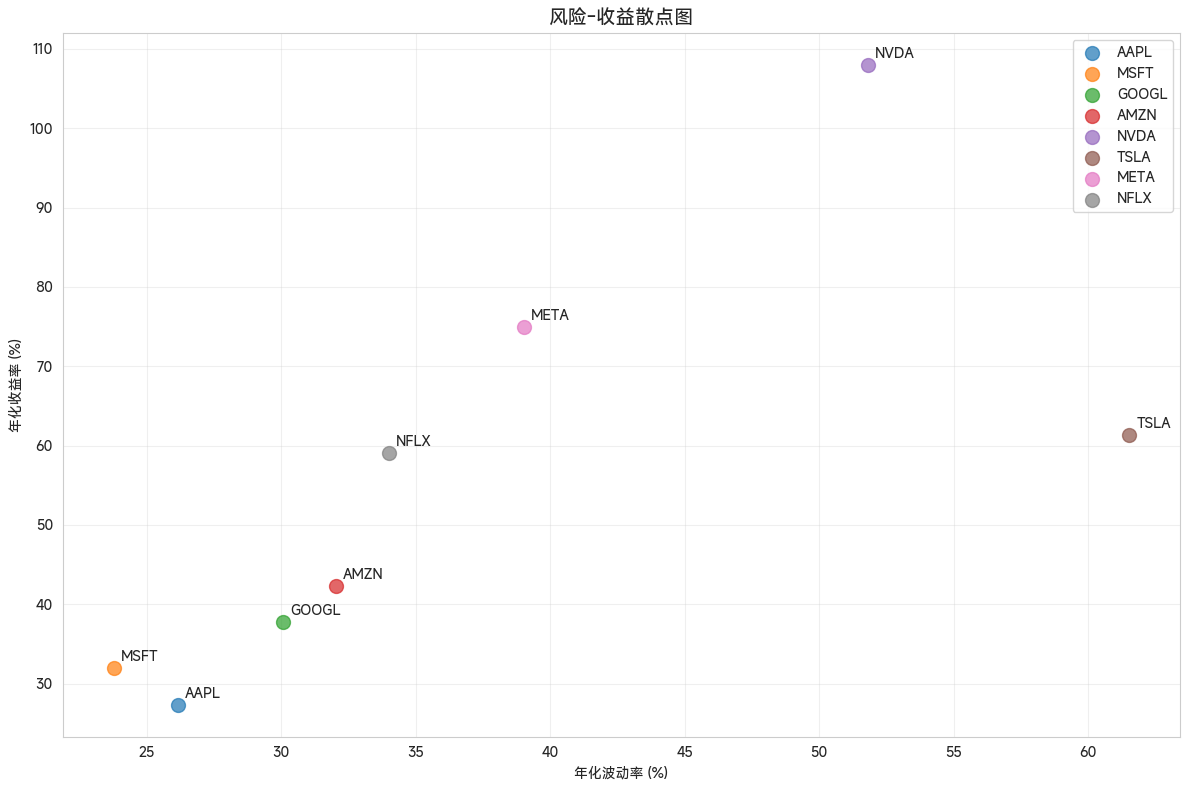

In [48]:
# %%
# === 5. 风险指标计算 ===
print("\n=== 5. 风险指标计算 ===")

def calculate_risk_metrics(returns, prices):
    """计算风险指标"""
    risk_metrics = {}
    
    for ticker in returns.columns:
        ret_series = returns[ticker].dropna()
        price_series = prices[ticker].dropna()
        
        # 基础风险指标
        annual_return = ret_series.mean() * 252
        annual_vol = ret_series.std() * np.sqrt(252)
        sharpe_ratio = annual_return / annual_vol if annual_vol != 0 else 0
        
        # 最大回撤
        cumulative = (1 + ret_series).cumprod()
        running_max = cumulative.expanding().max()
        drawdown = (cumulative - running_max) / running_max
        max_drawdown = drawdown.min()
        
        # VaR和CVaR (95%置信水平)
        var_95 = np.percentile(ret_series, 5)
        cvar_95 = ret_series[ret_series <= var_95].mean()
        
        # Sortino比率 (只考虑下行波动)
        downside_returns = ret_series[ret_series < 0]
        downside_vol = downside_returns.std() * np.sqrt(252) if len(downside_returns) > 0 else 0
        sortino_ratio = annual_return / downside_vol if downside_vol != 0 else 0
        
        # 偏度和峰度
        skewness = ret_series.skew()
        kurtosis = ret_series.kurtosis()
        
        risk_metrics[ticker] = {
            '年化收益率': annual_return,
            '年化波动率': annual_vol,
            '夏普比率': sharpe_ratio,
            'Sortino比率': sortino_ratio,
            '最大回撤': max_drawdown,
            'VaR_95%': var_95,
            'CVaR_95%': cvar_95,
            '偏度': skewness,
            '峰度': kurtosis
        }
    
    return pd.DataFrame(risk_metrics).T

# 计算风险指标
risk_metrics = calculate_risk_metrics(df_returns, df_prices)
print("风险指标统计:")
print(risk_metrics.round(4))

# 风险收益散点图
plt.figure(figsize=(12, 8))
for ticker in TICKERS:
    annual_return = risk_metrics.loc[ticker, '年化收益率'] * 100
    annual_vol = risk_metrics.loc[ticker, '年化波动率'] * 100
    plt.scatter(annual_vol, annual_return, s=100, alpha=0.7, label=ticker)
    plt.annotate(ticker, (annual_vol, annual_return), xytext=(5, 5), 
                textcoords='offset points', fontsize=10)

plt.xlabel('年化波动率 (%)')
plt.ylabel('年化收益率 (%)')
plt.title('风险-收益散点图', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [49]:
# %%
# === 6. 投资组合分析 ===
print("\n=== 6. 投资组合分析 ===")

# 等权重组合
equal_weight_portfolio = df_returns.mean(axis=1)

# 计算各种权重策略
def optimize_portfolio_weights(returns, method='min_variance'):
    """计算最优权重"""
    cov_matrix = returns.cov()
    
    if method == 'min_variance':
        # 最小方差权重
        inv_cov = np.linalg.pinv(cov_matrix.values)
        ones = np.ones((len(returns.columns), 1))
        weights = (inv_cov @ ones) / (ones.T @ inv_cov @ ones)
        return pd.Series(weights.flatten(), index=returns.columns)
    
    elif method == 'risk_parity':
        # 风险平价权重 (简化版：1/波动率权重)
        vols = returns.std()
        inv_vol_weights = (1 / vols) / (1 / vols).sum()
        return inv_vol_weights

# 计算不同组合策略
portfolio_strategies = {}

# 等权重组合
equal_weights = pd.Series(1/len(TICKERS), index=TICKERS)
portfolio_strategies['等权重'] = (df_returns * equal_weights).sum(axis=1)

# 风险平价组合
risk_parity_weights = optimize_portfolio_weights(df_returns, 'risk_parity')
portfolio_strategies['风险平价'] = (df_returns * risk_parity_weights).sum(axis=1)

# 最小方差组合
try:
    min_var_weights = optimize_portfolio_weights(df_returns, 'min_variance')
    portfolio_strategies['最小方差'] = (df_returns * min_var_weights).sum(axis=1)
except:
    print("最小方差组合计算失败，跳过")

# 组合业绩比较
portfolio_performance = pd.DataFrame()
for strategy_name, strategy_returns in portfolio_strategies.items():
    portfolio_performance[strategy_name] = {
        '年化收益率(%)': strategy_returns.mean() * 252 * 100,
        '年化波动率(%)': strategy_returns.std() * np.sqrt(252) * 100,
        '夏普比率': (strategy_returns.mean() * 252) / (strategy_returns.std() * np.sqrt(252)),
        '最大回撤(%)': ((1 + strategy_returns).cumprod() / 
                       (1 + strategy_returns).cumprod().expanding().max() - 1).min() * 100
    }

portfolio_performance = pd.DataFrame(portfolio_performance).T
print("投资组合策略比较:")
print(portfolio_performance.round(3))

# 组合权重显示
weights_comparison = pd.DataFrame({
    '等权重': equal_weights,
    '风险平价': risk_parity_weights
})

if 'min_var_weights' in locals():
    weights_comparison['最小方差'] = min_var_weights

print("\n组合权重分配:")
print((weights_comparison * 100).round(2))


=== 6. 投资组合分析 ===
投资组合策略比较:
      年化收益率(%)  年化波动率(%)   夏普比率  最大回撤(%)
等权重     55.329    26.672  2.074  -26.398
风险平价    49.727    24.521  2.028  -24.651
最小方差    24.777    20.211  1.226  -21.934

组合权重分配:
        等权重   风险平价   最小方差
AAPL   12.5  16.24  34.82
AMZN   12.5  13.27   0.44
GOOGL  12.5  14.13  17.07
META   12.5  10.89  -6.37
MSFT   12.5  17.87  52.23
NFLX   12.5  12.49  15.44
NVDA   12.5   8.20  -8.72
TSLA   12.5   6.91  -4.90



=== 7. 配对交易分析 ===
协整股票配对 (P值 < 0.05):
     股票1    股票2      P值
1   AMZN   META  0.0112
0   AMZN  GOOGL  0.0366
3   META   NVDA  0.0460
2  GOOGL   NVDA  0.0487

最佳配对分析: AMZN vs META
协整P值: 0.0112
当前Z-Score: -0.134


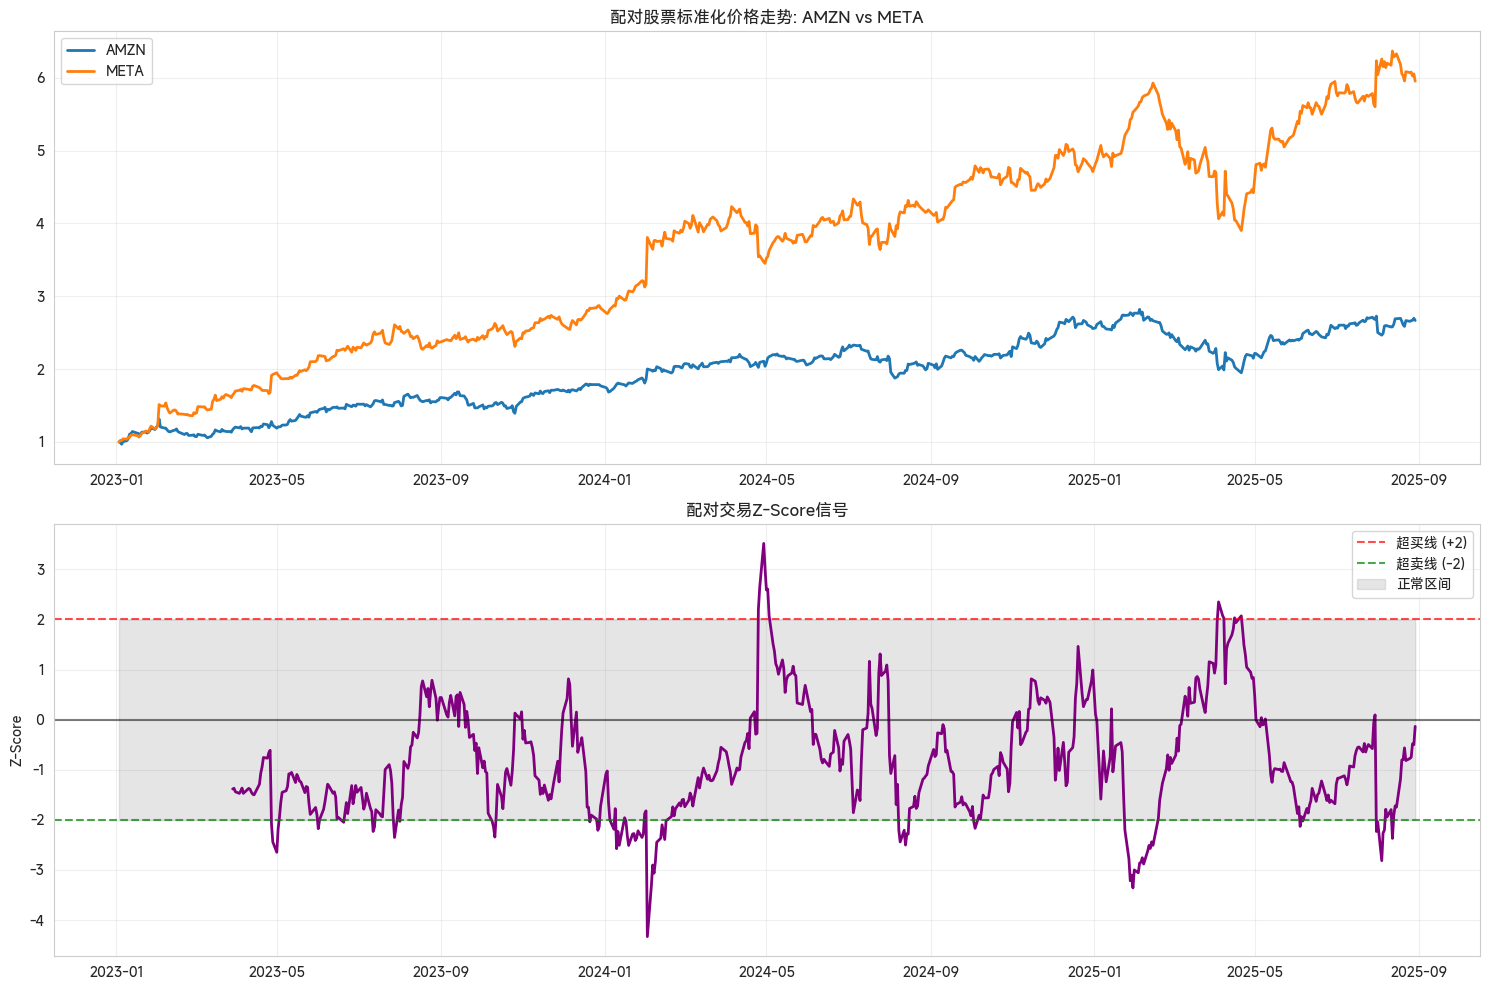

In [50]:
# %%
# === 7. 配对交易分析 ===
print("\n=== 7. 配对交易分析 ===")

def find_cointegrated_pairs(prices, significance_level=0.05):
    """寻找协整配对"""
    from statsmodels.tsa.stattools import coint
    
    n = len(prices.columns)
    pvalue_matrix = np.ones((n, n))
    pairs = []
    
    for i in range(n):
        for j in range(i+1, n):
            stock1, stock2 = prices.columns[i], prices.columns[j]
            try:
                _, pvalue, _ = coint(prices[stock1], prices[stock2])
                pvalue_matrix[i, j] = pvalue
                
                if pvalue < significance_level:
                    pairs.append((stock1, stock2, pvalue))
            except:
                continue
    
    return pairs, pvalue_matrix

# 寻找协整配对
try:
    cointegrated_pairs, pvalue_matrix = find_cointegrated_pairs(df_prices)
    
    if cointegrated_pairs:
        pairs_df = pd.DataFrame(cointegrated_pairs, 
                               columns=['股票1', '股票2', 'P值'])
        pairs_df = pairs_df.sort_values('P值')
        print("协整股票配对 (P值 < 0.05):")
        print(pairs_df.round(4))
        
        # 分析最佳配对
        if len(pairs_df) > 0:
            best_pair = pairs_df.iloc[0]
            stock1, stock2 = best_pair['股票1'], best_pair['股票2']
            
            # 计算价差和Z-score
            spread = df_prices[stock1] - df_prices[stock2]
            z_score = (spread - spread.rolling(60).mean()) / spread.rolling(60).std()
            
            print(f"\n最佳配对分析: {stock1} vs {stock2}")
            print(f"协整P值: {best_pair['P值']:.4f}")
            print(f"当前Z-Score: {z_score.iloc[-1]:.3f}")
            
            # 可视化配对
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
            
            # 标准化价格走势
            ax1.plot(df_prices.index, df_prices[stock1] / df_prices[stock1].iloc[0], 
                    label=stock1, linewidth=2)
            ax1.plot(df_prices.index, df_prices[stock2] / df_prices[stock2].iloc[0], 
                    label=stock2, linewidth=2)
            ax1.set_title(f'配对股票标准化价格走势: {stock1} vs {stock2}')
            ax1.legend()
            ax1.grid(True, alpha=0.3)
            
            # Z-Score走势
            ax2.plot(z_score.index, z_score, color='purple', linewidth=2)
            ax2.axhline(y=2, color='r', linestyle='--', alpha=0.7, label='超买线 (+2)')
            ax2.axhline(y=-2, color='g', linestyle='--', alpha=0.7, label='超卖线 (-2)')
            ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5)
            ax2.fill_between(z_score.index, -2, 2, alpha=0.2, color='gray', label='正常区间')
            ax2.set_title('配对交易Z-Score信号')
            ax2.set_ylabel('Z-Score')
            ax2.legend()
            ax2.grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.show()
    else:
        print("未找到显著的协整配对")
        
except ImportError:
    print("需要安装 statsmodels 库来进行协整检验")
except Exception as e:
    print(f"配对交易分析出错: {e}")

In [51]:
# === 8. 动量和反转策略分析 ===
print("\n=== 8. 动量和反转策略分析 ===")

# 计算不同期间的动量指标
momentum_periods = [5, 10, 20, 60]
momentum_scores = pd.DataFrame(index=df_prices.index)

for period in momentum_periods:
    for ticker in TICKERS:
        col_name = f'{ticker}_momentum_{period}d'
        momentum_scores[col_name] = df_prices[ticker].pct_change(period)

# 最新动量评分
latest_momentum = pd.DataFrame()
for ticker in TICKERS:
    latest_momentum[ticker] = {
        f'{period}日动量(%)': momentum_scores[f'{ticker}_momentum_{period}d'].iloc[-1] * 100
        for period in momentum_periods
    }

latest_momentum = pd.DataFrame(latest_momentum).T
print("最新动量评分:")
print(latest_momentum.round(2))

# 动量排名策略回测
def momentum_strategy_backtest(returns, prices, lookback=20, rebalance=20):
    """动量策略回测"""
    strategy_returns = []
    
    for i in range(lookback + rebalance, len(returns)):
        # 计算过去lookback天的收益率
        end_date = returns.index[i - rebalance]
        start_date = returns.index[i - rebalance - lookback]
        
        period_returns = prices.loc[end_date] / prices.loc[start_date] - 1
        
        # 选择排名前3的股票等权配置
        top_stocks = period_returns.nlargest(3).index
        
        # 计算未来rebalance天的组合收益
        future_returns = returns.iloc[i-rebalance:i][top_stocks].mean(axis=1)
        strategy_returns.extend(future_returns.tolist())
    
    return pd.Series(strategy_returns)

# 执行动量策略回测
momentum_strategy = momentum_strategy_backtest(df_returns, df_prices)

print(f"\n动量策略回测结果:")
print(f"策略年化收益率: {momentum_strategy.mean() * 252 * 100:.2f}%")
print(f"策略年化波动率: {momentum_strategy.std() * np.sqrt(252) * 100:.2f}%")
print(f"策略夏普比率: {(momentum_strategy.mean() * 252) / (momentum_strategy.std() * np.sqrt(252)):.3f}")


=== 8. 动量和反转策略分析 ===
最新动量评分:
       5日动量(%)  10日动量(%)  20日动量(%)  60日动量(%)
AAPL      1.92      0.24     14.84     14.59
MSFT     -0.11     -2.43     -3.16      9.41
GOOGL     3.31      4.42     12.57     26.85
AMZN      0.07     -0.88      6.64     10.51
NVDA     -2.14     -3.47      0.26     22.74
TSLA     -1.81      1.00     10.32      0.55
META     -2.13     -5.93     -1.51      7.46
NFLX      0.30     -2.48      4.29     -2.53

动量策略回测结果:
策略年化收益率: 58.12%
策略年化波动率: 30.66%
策略夏普比率: 1.896


In [52]:
# %%
# === 9. 综合评分系统 ===
print("\n=== 9. 综合评分系统 ===")

def calculate_composite_score(prices, returns, technical_indicators):
    """计算综合评分"""
    scores = pd.DataFrame(index=TICKERS)
    
    for ticker in TICKERS:
        # 技术面评分 (0-100)
        rsi = technical_indicators[f'{ticker}_RSI'].iloc[-1]
        bb_pos = technical_indicators[f'{ticker}_BB_Position'].iloc[-1]
        macd = technical_indicators[f'{ticker}_MACD'].iloc[-1]
        macd_signal = technical_indicators[f'{ticker}_MACD_Signal'].iloc[-1]
        
        # RSI评分 (30-70为中性，过高过低扣分)
        if 30 <= rsi <= 70:
            rsi_score = 50 + (50 - abs(rsi - 50))
        else:
            rsi_score = max(0, 50 - abs(rsi - 50))
        
        # 布林带位置评分
        bb_score = max(0, min(100, bb_pos * 100))
        
        # MACD评分
        macd_score = 60 if macd > macd_signal else 40
        
        # 基本面评分 (基于风险调整收益)
        annual_return = returns[ticker].mean() * 252
        annual_vol = returns[ticker].std() * np.sqrt(252)
        sharpe = annual_return / annual_vol if annual_vol > 0 else 0
        fundamental_score = min(100, max(0, 50 + sharpe * 20))
        
        # 动量评分
        momentum_20d = (prices[ticker].iloc[-1] / prices[ticker].iloc[-21] - 1)
        momentum_score = min(100, max(0, 50 + momentum_20d * 200))
        
        # 综合评分 (各项权重)
        composite = (rsi_score * 0.2 + bb_score * 0.2 + macd_score * 0.2 + 
                    fundamental_score * 0.3 + momentum_score * 0.1)
        
        scores.loc[ticker] = {
            'RSI评分': rsi_score,
            '布林带评分': bb_score,
            'MACD评分': macd_score,
            '基本面评分': fundamental_score,
            '动量评分': momentum_score,
            '综合评分': composite
        }
    
    return scores.round(2)

# 计算综合评分
composite_scores = calculate_composite_score(df_prices, df_returns, df_technical)
composite_scores = composite_scores.sort_values('综合评分', ascending=False)

print("股票综合评分排名:")
print(composite_scores)

# 评分可视化
plt.figure(figsize=(12, 8))
scores_for_plot = composite_scores['综合评分'].values
tickers_for_plot = composite_scores.index
colors = ['green' if score >= 70 else 'orange' if score >= 50 else 'red' for score in scores_for_plot]

bars = plt.bar(tickers_for_plot, scores_for_plot, color=colors, alpha=0.7, edgecolor='black')
plt.axhline(y=70, color='green', linestyle='--', alpha=0.7, label='优秀线 (70)')
plt.axhline(y=50, color='orange', linestyle='--', alpha=0.7, label='及格线 (50)')
plt.xlabel('股票代码')
plt.ylabel('综合评分')
plt.title('股票综合评分排名', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3, axis='y')

# 在柱状图上标注分数
for bar, score in zip(bars, scores_for_plot):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{score:.0f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()



=== 9. 综合评分系统 ===


ValueError: Must have equal len keys and value when setting with an iterable

In [ ]:
# %%
# === 10. 总结报告 ===
print("\n" + "="*60)
print("=== 多股票量化分析总结报告 ===")
print("="*60)

print(f"\n📊 数据概况:")
print(f"• 分析股票: {', '.join(TICKERS)}")
print(f"• 数据期间: {START_DATE} 至 {END_DATE}")
print(f"• 交易日数: {len(df_prices)} 天")

print(f"\n🏆 业绩排名 (按总收益率):")
total_returns = ((df_prices.iloc[-1] / df_prices.iloc[0] - 1) * 100).sort_values(ascending=False)
for i, (ticker, ret) in enumerate(total_returns.items(), 1):
    print(f"{i:2d}. {ticker}: {ret:+7.2f}%")

print(f"\n⚡ 综合评分排名:")
for i, (ticker, score) in enumerate(composite_scores['综合评分'].items(), 1):
    status = "🟢" if score >= 70 else "🟡" if score >= 50 else "🔴"
    print(f"{i:2d}. {ticker}: {score:5.1f} {status}")

print(f"\n💡 投资建议:")
top_stocks = composite_scores.head(3).index.tolist()
print(f"• 推荐关注: {', '.join(top_stocks)}")

high_risk_stocks = risk_metrics.nlargest(2, '年化波动率').index.tolist()
print(f"• 高风险股票: {', '.join(high_risk_stocks)}")

if 'cointegrated_pairs' in locals() and len(cointegrated_pairs) > 0:
    print(f"• 配对交易机会: {len(cointegrated_pairs)} 组")

print(f"\n📈 策略建议:")